<a href="https://colab.research.google.com/github/AsutoshDalei/Deep-Neural-Networks/blob/master/SentimentAnalysisBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install kaggle --quiet
# ! mkdir ~/.kaggle
# ! chmod 600 ~/.kaggle/kaggle.json

In [1]:
!pip install torchinfo --quiet

# Sentiment Analysis using BERT

## Importing necessary packages

In [19]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

%autosave 30

Autosaving every 30 seconds


In [2]:
%%time
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

# import kagglehub

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 247 ms, sys: 119 ms, total: 367 ms
Wall time: 788 ms


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from transformers import BertTokenizer, BertModel, AdamW, AutoTokenizer, AutoModel

In [4]:
import warnings
warnings.filterwarnings('ignore')

telltimefnx = lambda :print('','='*100,f"\nTime Now: {pd.Timestamp.now().strftime('%Y.%m.%d %I:%M %p')}",'\n','='*100)
telltimefnx()

Time Now: 2025.01.14 05:00 PM 


In [6]:
# kagglehub.login()

# !export KAGGLE_USERNAME="asutoshdalei"
# !export KAGGLE_KEY="863d091421d761c7669da64292f5c612"

## Importing Data

In [7]:
# %%time
# path = kagglehub.dataset_download("nelgiriyewithana/emotions")

# print("Path to dataset files:", path)

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data = pd.read_csv("/kaggle/input/emotions/text.csv",usecols=['text','label'])
data.head()

/kaggle/input/emotions/text.csv


,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [9]:
labelMap = {0:'sadness',1:'joy',2:'love',3:'anger',4:'fear',5:'surprise'}

In [10]:
%%time
fnx = lambda x:labelMap[x['label']]
data = data.assign(labelTone = data.apply(fnx,axis=1))
data.head()

CPU times: user 1.89 s, sys: 39.1 ms, total: 1.92 s
Wall time: 1.92 s


,text,label,labelTone
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax a...,0,sadness
2,i gave up my internship with the dmrg and am f...,4,fear
3,i dont know i feel so lost,0,sadness
4,i am a kindergarten teacher and i am thoroughl...,4,fear


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       416809 non-null  object
 1   label      416809 non-null  int64 
 2   labelTone  416809 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.5+ MB


## Data Exploration

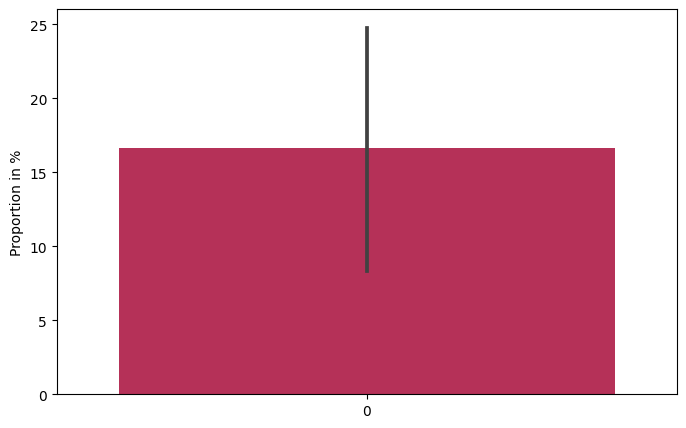

In [12]:
cmap = 'rocket'

plt.figure(figsize=(8,5),dpi=100)
sns.barplot(data['labelTone'].value_counts(normalize=True)*100, palette=cmap)
plt.ylabel("Proportion in %")
plt.show()

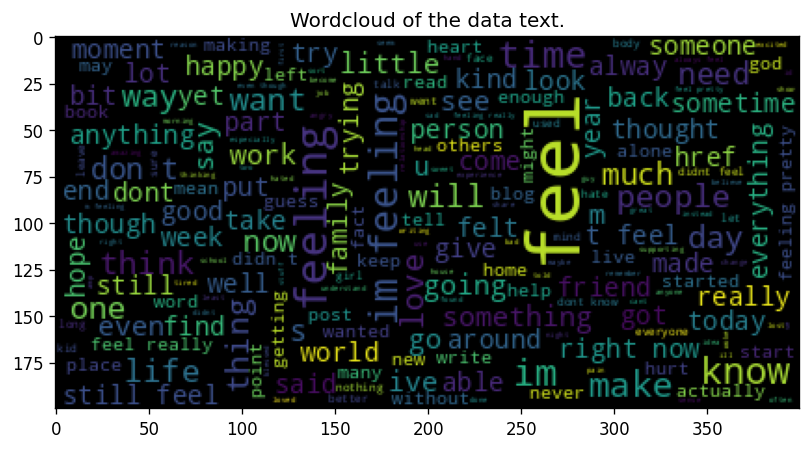

CPU times: user 16.5 s, sys: 957 ms, total: 17.4 s
Wall time: 17.1 s


In [13]:
%%time
wordcloud = WordCloud(background_color ='black', max_words=200, max_font_size=40, scale=1).generate(" ".join(data['text'].values))

plt.figure(figsize=(8,7),dpi=120)
plt.imshow(wordcloud)
plt.title("Wordcloud of the data text.")
plt.show()

In [14]:
%%time
fnx = lambda row:len(row['text'].split(' '))
data = data.assign(wordlen = data.apply(fnx,axis=1))

fnx = lambda row:len(row['text'])
data = data.assign(charlen = data.apply(fnx,axis=1))

data.head()

CPU times: user 4.43 s, sys: 62.4 ms, total: 4.49 s
Wall time: 4.49 s


,text,label,labelTone,wordlen,charlen
0,i just feel really helpless and heavy hearted,4,fear,8,45
1,ive enjoyed being able to slouch about relax a...,0,sadness,45,234
2,i gave up my internship with the dmrg and am f...,4,fear,12,63
3,i dont know i feel so lost,0,sadness,7,26
4,i am a kindergarten teacher and i am thoroughl...,4,fear,42,222


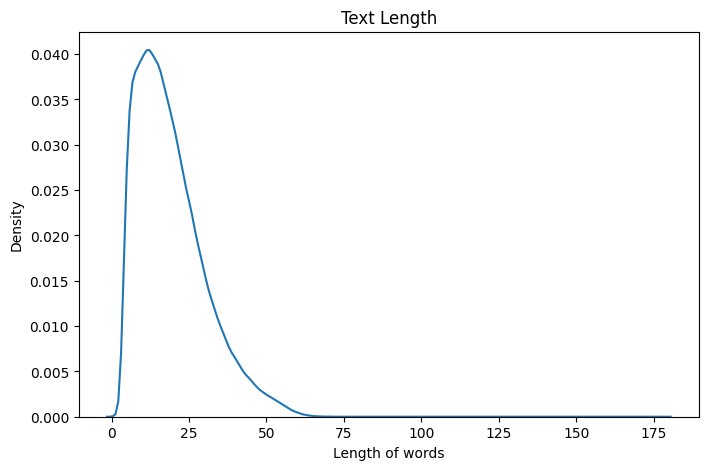

In [15]:
plt.figure(figsize=(8,5),dpi=100)
# sns.histplot(data=data, x='wordlen',hue='labelTone',binwidth=5)
sns.kdeplot(data=data, x='wordlen')
plt.xlabel("Length of words")
plt.title("Text Length")
plt.show()

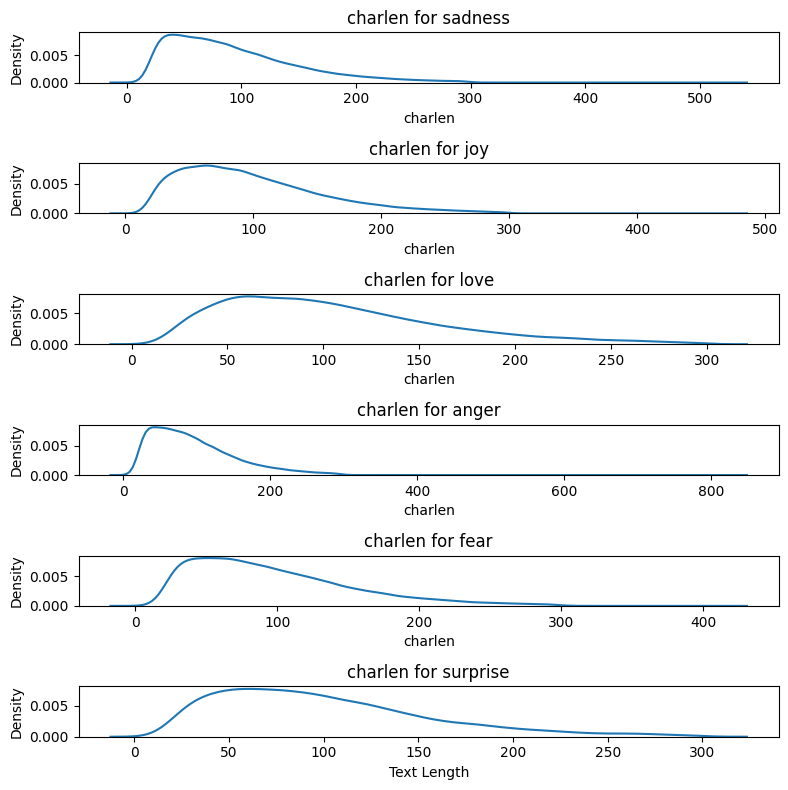

In [16]:
measure = 'wordlen'
measure = 'charlen'

fig,ax = plt.subplots(data['label'].nunique(),1, figsize=(8,8))
for lab in data['label'].unique():
  sns.kdeplot(data=data[data['label']==lab], x=measure,ax=ax[lab])
  ax[lab].set_title(f"{measure} for {labelMap[lab]}")

fig.tight_layout()
plt.xlabel("Text Length")
plt.show()

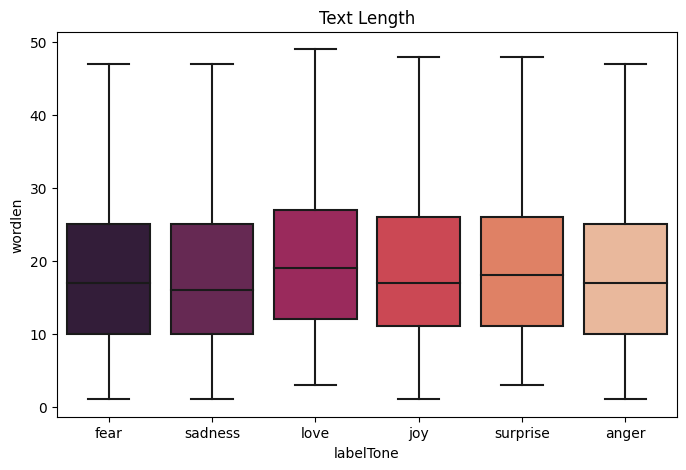

In [17]:
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(data=data,x='labelTone', y='wordlen', palette=cmap,showfliers=False)
plt.title("Text Length")
plt.show()

In [18]:
%%time
texts = data['text'].str.split().values.tolist()
corpus = [word for i in texts for word in i]

corpus = Counter(corpus)

CPU times: user 2.66 s, sys: 342 ms, total: 3 s
Wall time: 2.99 s


In [19]:
n = 100

wordCommon,countCommon = [],[]
for word in corpus.most_common(n=n):
  if word[0] not in stopWords_nltk:
    wordCommon.append(word[0])
    countCommon.append(word[1])

print("Common Words:", len(wordCommon))

Common Words: 30


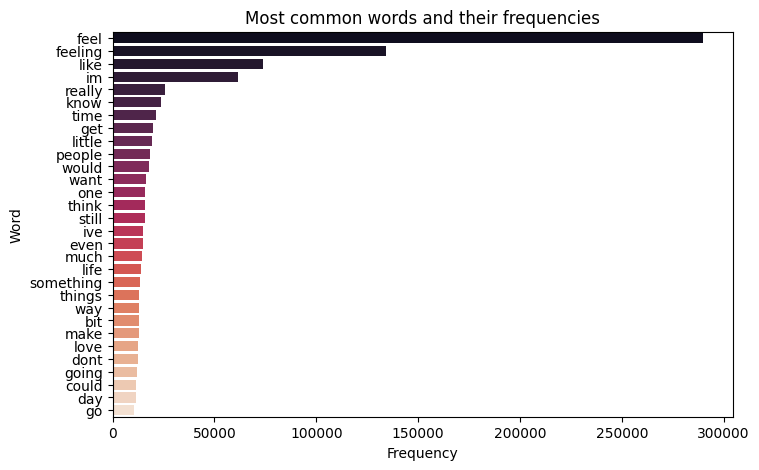

In [20]:
plt.figure(figsize=(8,5),dpi=100)
sns.barplot(x=countCommon, y=wordCommon, palette=cmap)
plt.title("Most common words and their frequencies")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

### BERT

In [30]:
%%time
model_checkpoint = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_checkpoint, do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

CPU times: user 192 ms, sys: 45.9 ms, total: 238 ms
Wall time: 1.37 s


In [31]:
tokenizer("i just feel really helpless and heavy hearted")
tokenizer("My name is Jhon Doe")

{'input_ids': [101, 2026, 2171, 2003, 1046, 8747, 18629, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [32]:
%%time
fnx = lambda row: tokenizer(row['text'], add_special_tokens=False)['input_ids']

dataToken = data.apply(fnx, axis=1)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11.2 µs


In [33]:
%%time
data = data.assign(tokenlen = dataToken.apply(len))
data.head()

NameError: name 'dataToken' is not defined

In [34]:
plt.figure(figsize=(8,5),dpi=100)
# sns.histplot(data=data, x='wordlen',hue='labelTone',binwidth=5)
sns.kdeplot(data=data, x='tokenlen',label='Token Length')
sns.kdeplot(data,x='charlen', label='Char Length')
plt.xlabel("Length")
plt.title("Token v/s Char Length Comparison")
plt.legend()
plt.show()

ValueError: Could not interpret value `tokenlen` for parameter `x`

<Figure size 800x500 with 0 Axes>

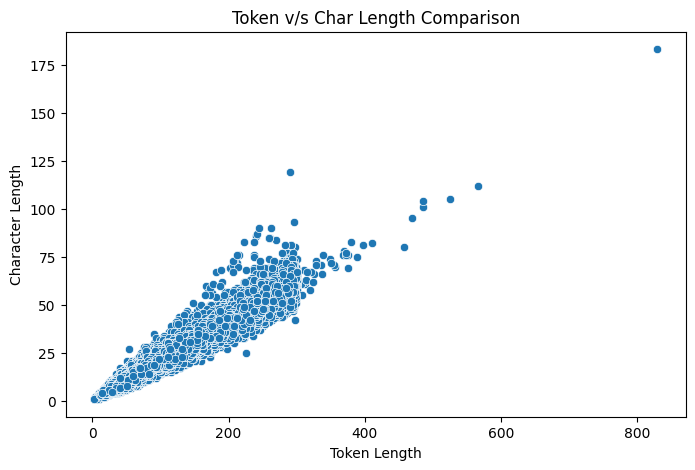

In [ ]:
plt.figure(figsize=(8,5),dpi=100)
sns.scatterplot(data=data,x='charlen',y='tokenlen')
plt.xlabel("Token Length")
plt.ylabel("Character Length")
plt.title("Token v/s Char Length Comparison")
plt.show()

In [5]:
def resultAnalysisFnx(ytrue,ypred,target_names=None):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names))
    else:
        print(classification_report(ytrue,ypred))

    conf_matrix = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(6, 4))
    if target_names != None:
        # sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names)
        sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names)

    else:
        # sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False)
        sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues', cbar=False)

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True)

## Model Development

In [24]:
print("Initial Data Length:",data.shape[0])
trainvalData, testData = train_test_split(data,test_size=0.3,stratify=data['label'])
print(f"TrainVal Split: {trainvalData.shape[0]} ({(trainvalData.shape[0]/data.shape[0])*100:.2g}%), Test Split: {testData.shape[0]} ({(testData.shape[0]/data.shape[0])*100:.2g}%)")

trainData, valData = train_test_split(trainvalData,test_size=0.3,stratify=trainvalData['label'])
print(f"Train Split: {trainData.shape[0]} ({(trainData.shape[0]/data.shape[0])*100:.2g}%), Val Split: {valData.shape[0]} ({(valData.shape[0]/data.shape[0])*100:.2g}%)")

Initial Data Length: 416809
TrainVal Split: 291766 (70%), Test Split: 125043 (30%)
Train Split: 204236 (49%), Val Split: 87530 (21%)


In [25]:
print("Total Label Distribution")
data['label'].value_counts(normalize=True)

Total Label Distribution


label
1    0.338445
0    0.290749
3    0.137514
4    0.114470
2    0.082901
5    0.035921
Name: proportion, dtype: float64

In [26]:
print("Training Label Distribution")
trainData['label'].value_counts(normalize=True)

Training Label Distribution


label
1    0.338447
0    0.290752
3    0.137512
4    0.114466
2    0.082904
5    0.035919
Name: proportion, dtype: float64

### PyTorch Dataset

In [27]:
class datasetGen(Dataset):
  def __init__(self,data,tokenizer):
    self.data = data
    self.tokenizer = tokenizer
    self.maxlen = 80

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    text = data.iloc[index]['text']
    label = data.iloc[index]['label']

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = self.maxlen,
        truncation = True,
        padding = "max_length",
        return_attention_mask = True,
        return_tensors = 'pt')

    return {'text':text,
            "input_id":encoding['input_ids'][0],
            "attention_mask":encoding['attention_mask'][0],
            "target":torch.tensor(label)
            }

In [28]:
trainDataGen = datasetGen(data=trainData,tokenizer=tokenizer)
valDataGen = datasetGen(data=valData,tokenizer=tokenizer)
testDataGen = datasetGen(data=testData,tokenizer=tokenizer)

# next(iter(trainDataGen))

In [29]:
%%time
batch_size = 32
train_loader = DataLoader(trainDataGen, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valDataGen, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testDataGen, batch_size=batch_size, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader))

6383 2736 3908
CPU times: user 556 µs, sys: 0 ns, total: 556 µs
Wall time: 502 µs


In [30]:
sample = next(iter(trainDataGen))
sample

{'text': 'i just feel really helpless and heavy hearted',
 'input_id': tensor([  101,  1045,  2074,  2514,  2428, 13346,  1998,  3082, 18627,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),


### Model Creation

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device in use:", device)

Device in use: cpu


In [36]:
bert = BertModel.from_pretrained(model_checkpoint)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [37]:
type(bert)

transformers.models.bert.modeling_bert.BertModel

* https://www.kaggle.com/code/alkidiarete/social-media-analysis-sentiment
* https://wellsr.com/python/fine-tuning-bert-for-sentiment-analysis-with-pytorch/
* https://niteshkumardew11.medium.com/fine-tuning-bert-base-using-pytorch-for-sentiment-analysis-c44a3ce79091


In [38]:
class bertModel(nn.Module):
  def __init__(self, numClasses):
    super(bertModel,self).__init__()

    self.bert = BertModel.from_pretrained(model_checkpoint)
    self.classifier = nn.Sequential(
        nn.Linear(self.bert.config.hidden_size,300),
        nn.Dropout(p=0.4),
        nn.Linear(300,100),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,numClasses)
        )

  def forward(self, input_id, attention_mask):
    outputs = self.bert(input_ids=input_id, attention_mask=attention_mask)
    # We are basically collecting the first token of each input (CLS token) and using it for classification. Interesting concept. Give it a read.
    x = outputs['last_hidden_state'][:, 0, :]
    x = self.classifier(x)
    return x


numClasses = data['label'].nunique()
print(f"Number of classes: {numClasses}")

model = bertModel(numClasses=numClasses)
# model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)
optimizer = AdamW(params=model.parameters(), lr = 2e-5)


Number of classes: 6


In [39]:
print(summary(model))

Layer (type:depth-idx)                                       Param #
bertModel                                                    --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,440,896
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Sequential: 1-2                                            --
│  

### Training & Testing Section

In [ ]:
%%time
telltimefnx()

numEpochs = 1

totLoss,totAcc, totLossV,totAccV = [],[] ,[],[]

for epc in range(numEpochs):
  model.train()

  runningLoss,correct,total = 0,0,0
  # ptr = 0

  for batch in train_loader:
    inp,att,label = batch['input_id'], batch['attention_mask'], batch['target']
    inp,att,label = inp.to(device),att.to(device),label.to(device)

    optimizer.zero_grad()

    output = model(inp,att)
    loss = criterion(output,label)

    loss.backward()
    optimizer.step()

    running_loss = loss.item()

    _,pred = torch.max(output,1)
    total += label.size(0)
    correct += (label==pred).sum().item()

    # ptr+=1
    # if (ptr%10==0):
    #   print(f"Batch#{ptr} complete")

  epcLoss = running_loss/len(train_loader)
  epcAcc = 100*correct/total

  totLoss.append(epcLoss)
  totAcc.append(epcAcc)

  print(f"Epoch {epc+1}/{numEpochs}, Loss: {epcLoss:.4f}, Accuracy: {epcAcc:.2f}%")

  model.eval()
  running_lossV,correctV,totalV = 0,0,0
  ptr = 0
  for batchV in val_loader:
    inpV,attV,labelV = batchV['input_id'], batchV['attention_mask'], batchV['target']
    inpV,attV,labelV = inpV.to(device),attV.to(device),labelV.to(device)

    outputV = model(inpV,attV)
    lossV = criterion(outputV,labelV)

    running_lossV += lossV.item()
    _,pred = torch.max(outputV,1)

    totalV += labelV.size(0)
    correctV += (pred==labelV).sum().item()

  epcLossV = running_lossV/len(val_loader)
  epcAccV = 100*correctV/totalV

  totLossV.append(epcLossV)
  totAccV.append(epcAccV)
  print(f"Validation Data: {epcLossV:.4f}, Validation Accuracy: {epcAccV:.2f}%")

telltimefnx()


PATH = "/content/sample_data/bertModel.pt"
torch.save(model.state_dict(), PATH)

Time Now: 2025.01.11 02:20 AM 
Epoch 1/1, Loss: 0.0000, Accuracy: 91.35%
Validation Data: 0.0998, Validation Accuracy: 94.15%
Time Now: 2025.01.11 03:11 AM 
CPU times: user 31min 3s, sys: 20min 31s, total: 51min 34s
Wall time: 52min 1s


In [40]:
# model = bertModel(numClasses=numClasses)
# model.load_state_dict(torch.load(PATH, weights_only=True))
# model.eval()
# model.to(device)

In [ ]:
model.eval()

test_correct = 0
test_total = 0

testActual, testPred = [], []
with torch.no_grad():
  for batchT in test_loader:
    inpT,attT,labelT = batchT['input_id'], batchT['attention_mask'], batchT['target']
    inpT,attT,labelT = inpT.to(device),attT.to(device),labelT.to(device)

    outputT = model(inpT,attT)
    lossT = criterion(outputT,labelT)

    _,pred = torch.max(outputT,1)

    test_total += labelT.size(0)
    test_correct += (pred == labelT).sum().item()

    testActual.extend(labelT.tolist())
    testPred.extend(pred.tolist())


print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

Test Accuracy: 94.16%


In [41]:
# testActual
# testPred
# ret = resultAnalysisFnx(testActual,testPred)

## Inferencing

In [ ]:
PATH = "/content/drive/MyDrive/Datasets/bertModel.pt"

model = bertModel(numClasses=numClasses)
model.load_state_dict(torch.load(PATH, weights_only=True, map_location=torch.device('cpu')))
model.eval()
model.to(device)

bertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
def inferenceTokenizer(text, model, tokenizer=tokenizer):
  encoding = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = 80,
        truncation = True,
        padding = "max_length",
        return_attention_mask = True,
        return_tensors = 'pt')
  enc_inf, att_inf = encoding['input_ids'][0].view(-1,80),encoding['attention_mask'].view(-1,80)
  with torch.no_grad():
    output_inf = model(enc_inf,att_inf)

  return torch.nn.functional.softmax(output_inf).view(-1)

In [ ]:
%%time

labelMap = {0:'sadness',1:'joy',2:'love',3:'anger',4:'fear',5:'surprise'}

text = "hello world. how are you today?"
text = "Why are you calling me these many times?"
text = "I am not very excited for this food."
text = "I can speak hindi"
# text = "Is it really tasty?"
infSample = inferenceTokenizer(text=text, model=model)

for i,lab in zip(labelMap,infSample):
  print(f"{labelMap[i]} : {infSample[i]*100:.2f}%")

sadness : 14.49%
joy : 62.99%
love : 2.96%
anger : 6.63%
fear : 10.71%
surprise : 2.23%
CPU times: user 487 ms, sys: 190 µs, total: 487 ms
Wall time: 980 ms


In [ ]:
text = "i am very sad and angry"
infSample = inferenceTokenizer(text=text, model=model)

for i,lab in zip(labelMap,infSample):
  print(f"{labelMap[i]} : {infSample[i]*100:.2f}%")

sadness : 99.17%
joy : 0.22%
love : 0.00%
anger : 0.42%
fear : 0.17%
surprise : 0.02%


----
## MiniBERT

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device in use:", device)

Device in use: cpu


In [22]:
tokenizer_mini = AutoTokenizer.from_pretrained("google/bert_uncased_L-4_H-512_A-8")

In [36]:
%%time
trainDataGen = datasetGen(data=trainData,tokenizer=tokenizer_mini)
valDataGen = datasetGen(data=valData,tokenizer=tokenizer_mini)
testDataGen = datasetGen(data=testData,tokenizer=tokenizer_mini)

# next(iter(trainDataGen))

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 15.3 µs


In [37]:
%%time
batch_size = 32
train_loader = DataLoader(trainDataGen, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valDataGen, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testDataGen, batch_size=batch_size, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader))

6383 2736 3908
CPU times: user 331 µs, sys: 0 ns, total: 331 µs
Wall time: 337 µs


In [38]:
from transformers import AutoModel
bert_mini = AutoModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8")

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

In [39]:
numParamsFnx = lambda model: sum(p.numel() for p in model.parameters())

bertParams = numParamsFnx(bert)
bertMiniParams = numParamsFnx(bert_mini)

print(f"Number of parameters in BERT Mini: {bertMiniParams}")
print(f"Number of parameters in BERT Base: {bertParams}")

print(f"BERT base is bigger than BERT mini by {100*(bertParams-bertMiniParams)/bertMiniParams: .3f}%")


Number of parameters in BERT Mini: 28763648
Number of parameters in BERT Base: 109482240
BERT base is bigger than BERT mini by  280.627%


In [12]:
class bertMiniModel(nn.Module):
  def __init__(self, numClasses):
    super(bertMiniModel,self).__init__()

    self.bert = AutoModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8")
    self.classifier = nn.Sequential(
        nn.Linear(self.bert.config.hidden_size,300),
        nn.Dropout(p=0.4),
        nn.Linear(300,100),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,numClasses)
        )

  def forward(self, input_id, attention_mask):
    outputs = self.bert(input_ids=input_id, attention_mask=attention_mask)
    # We are basically collecting the first token of each input (CLS token) and using it for classification. Interesting concept. Give it a read.
    x = outputs['last_hidden_state'][:, 0, :]
    x = self.classifier(x)
    return x


numClasses = data['label'].nunique()

print(f"Number of classes: {numClasses}")

model = bertMiniModel(numClasses=numClasses)
model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)
optimizer = AdamW(params=model.parameters(), lr = 2e-5)


Number of classes: 6


pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

In [70]:
print(summary(model))

Layer (type:depth-idx)                                       Param #
bertMiniModel                                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   15,627,264
│    │    └─Embedding: 3-2                                   262,144
│    │    └─Embedding: 3-3                                   1,024
│    │    └─LayerNorm: 3-4                                   1,024
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  12,609,536
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      262,656
│    │    └─Tanh: 3-8                                        --
├─Sequential: 1-2                                            --
│  

In [71]:
%%time
telltimefnx()

numEpochs = 3

totLoss,totAcc, totLossV,totAccV = [],[] ,[],[]

for epc in range(numEpochs):
    stime = time.time()
    model.train()
    
    runningLoss,correct,total = 0,0,0

    for batch in train_loader:
        inp,att,label = batch['input_id'], batch['attention_mask'], batch['target']
        inp,att,label = inp.to(device),att.to(device),label.to(device)
        
        optimizer.zero_grad()
        
        output = model(inp,att)
        loss = criterion(output,label)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _,pred = torch.max(output,1)
        total += label.size(0)
        correct += (label==pred).sum().item()
    epcLoss = running_loss/len(train_loader)
    epcAcc = 100*correct/total
    
    totLoss.append(epcLoss)
    totAcc.append(epcAcc)

    print(f"Epoch {epc+1}/{numEpochs}, Loss: {epcLoss:.4f}, Accuracy: {epcAcc:.2f}%, TimeCons: {time.time()-stime:.2f}")
    
    model.eval()
    running_lossV,correctV,totalV = 0,0,0
    ptr = 0
    for batchV in val_loader:
        inpV,attV,labelV = batchV['input_id'], batchV['attention_mask'], batchV['target']
        inpV,attV,labelV = inpV.to(device),attV.to(device),labelV.to(device)
        
        outputV = model(inpV,attV)
        lossV = criterion(outputV,labelV)
        
        running_lossV += lossV.item()
        _,pred = torch.max(outputV,1)
        
        totalV += labelV.size(0)
        correctV += (pred==labelV).sum().item()

    epcLossV = running_lossV/len(val_loader)
    epcAccV = 100*correctV/totalV
    
    totLossV.append(epcLossV)
    totAccV.append(epcAccV)
    print(f"Validation Data: {epcLossV:.4f}, Validation Accuracy: {epcAccV:.2f}%")

telltimefnx()


PATH = "/content/sample_data/bertMiniModel.pt"
torch.save(model.state_dict(), PATH)

Time Now: 2025.01.14 04:17 PM 
Epoch 1/3, Loss: 0.0000, Accuracy: 88.53%, TimeCons: 418.57
Validation Data: 0.1049, Validation Accuracy: 94.09%
Epoch 2/3, Loss: 0.0000, Accuracy: 93.89%, TimeCons: 418.33
Validation Data: 0.0923, Validation Accuracy: 94.26%
Epoch 3/3, Loss: 0.0000, Accuracy: 94.00%, TimeCons: 417.90
Validation Data: 0.0846, Validation Accuracy: 94.52%
Time Now: 2025.01.14 04:43 PM 
CPU times: user 25min 50s, sys: 1.39 s, total: 25min 51s
Wall time: 25min 52s


In [86]:
%%time
PATH = '/kaggle/working/bertMiniModel.pt'
torch.save(model.state_dict(), PATH)

CPU times: user 90 ms, sys: 114 ms, total: 204 ms
Wall time: 202 ms


In [42]:
PATH_load = '/kaggle/input/minibert/pytorch/default/1/bertMiniModel.pt'

model = bertMiniModel(numClasses=numClasses)
model.to(device)
model.load_state_dict(torch.load(PATH_load, weights_only=True,map_location=torch.device('cpu')))
model.eval()
model.to(device)

bertMiniModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_a

In [ ]:
model.eval()

test_correct = 0
test_total = 0

testActual, testPred = [], []
with torch.no_grad():
    stime = time.time()
    for batchT in test_loader:
        inpT,attT,labelT = batchT['input_id'], batchT['attention_mask'], batchT['target']
        inpT,attT,labelT = inpT.to(device),attT.to(device),labelT.to(device)
        
        outputT = model(inpT,attT)
        lossT = criterion(outputT,labelT)
        
        _,pred = torch.max(outputT,1)
        
        test_total += labelT.size(0)
        test_correct += (pred == labelT).sum().item()
        
        testActual.extend(labelT.tolist())
        testPred.extend(pred.tolist())

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%, TimeCons:{time.time()-stime:.3f}")

## Inferencing

In [23]:
def inferenceTokenizer(text, model, tokenizer=tokenizer_mini):
  encoding = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = 80,
        truncation = True,
        padding = "max_length",
        return_attention_mask = True,
        return_tensors = 'pt')
  enc_inf, att_inf = encoding['input_ids'][0].view(-1,80),encoding['attention_mask'].view(-1,80)
  with torch.no_grad():
    output_inf = model(enc_inf,att_inf)

  return torch.nn.functional.softmax(output_inf).view(-1)

In [29]:
%%time

labelMap = {0:'sadness',1:'joy',2:'love',3:'anger',4:'fear',5:'surprise'}

text = "hello world. how are you today?"
text = "Why are you calling me these many times?"
text = "I am not very excited for this food."
text = "I can speak hindi"
text = "tell me the quickest way to get to the airport?"
infSample = inferenceTokenizer(text=text, model=model)

for i,lab in zip(labelMap,infSample):
  print(f"{labelMap[i]} : {infSample[i]*100:.2f}%")

sadness : 15.33%
joy : 6.00%
love : 1.01%
anger : 33.21%
fear : 42.93%
surprise : 1.52%
CPU times: user 113 ms, sys: 6.52 ms, total: 119 ms
Wall time: 61 ms
